Seguimiento de Casos de Feminicidios usando Técnicas de Minería de Texto
=======================

El observatorio Feminicidios Colombia (https://observatoriofeminicidioscolombia.org/) tiene un registro de los feminicidios presentados en territorio Nacional desde 2017. En este proyecto, se hace un seguimiento a cada uno de los casos presentados.

Web Scraping de la página web del Observatorio Feminicidios Colombia y obtención del link de cada boletín nacional de Feminicidios
-----------
En esta primera etapa se hace web scrapping a la url https://www.observatoriofeminicidioscolombia.org/index.php/seguimiento/boletin-nacional, donde se encuentran los links a los boletines mensuales (y otros boletines especiales) de Feminicidios en Colombia. Se obtinen únicamente los links de los boletines mensuales y se hace nuevamente web scraping sobre cada uno de ellos para obtener el link directo al pdf que contiene cada boletín.

In [1]:
import requests
from bs4 import BeautifulSoup

headers = {
    'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.12; rv:55.0) Gecko/20100101 Firefox/55.0',
}

web_page = requests.get('https://www.observatoriofeminicidioscolombia.org/index.php/seguimiento/boletin-nacional', headers=headers)
soup = BeautifulSoup(web_page.text, 'html.parser')
links_pdf=[]
for link in soup.find_all('a'):
    links=link.get('href')
    
    if links is not None and ('boletin-mensual' in links or 'balance-mensual' in links or 'agosto-2017' in links):
        links_pdf.append(links)
        
links_pdf=list(set(links_pdf))

pdf_=[]
for link in links_pdf:
    
    page=requests.get('https://www.observatoriofeminicidioscolombia.org'+link, headers=headers)
    soup = BeautifulSoup(page.text, 'html.parser')
    for i in soup.find_all('a'):
        pdf_url=i.get('href')
        if 'attachments' in pdf_url and ' ' not in pdf_url:

            pdf_.append(pdf_url)
pdf_=list(set(pdf_))

Descarga de los boletines en pdf
------------
Teniendo los links de los pdf que contienen los boletines mensuales, se hace una descarga de todos ellos en la carpeta "boletines_pdf".

In [2]:
import urllib

for i in pdf_:
    url = 'https://www.observatoriofeminicidioscolombia.org'+i
    dire='D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_pdf/'+i[21:24]+'.pdf'
    response = urllib.request.urlopen(urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko)\
    Chrome/51.0.2704.103 Safari/537.36', 'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8'}))
    file = open(dire, 'wb')
    file.write(response.read())
    file.close()

Aplicación de OCR a boletines formato imagen
-----
En vista de que algunos boletines no contienen texto sino imagenes, es necesario aplicar técnicas de reconocimiento óptico de caracteres (OCR) . En vista que aplicar OCR no hace parte de los objetivos de este proyecto, se usa un lector de pdf que dentro de sus funcionalidades tiene integrada la aplicación de OCR.
Se realiza este proceso sobre los documentos conformados enteramente por imágenes y se guardan en una nueva carpeta llamada "boletines_pdf_OCR"

Obtención de Boletines en archivos tipo texto
--------
A continuación se leen los pdf previamente procesados y se guardan en un archivo tipo texto en la carpeta "boletines_text"

In [13]:
from io import StringIO
from collections import Counter
import re

#from pdfminer.converter import TextConverter
#from pdfminer.layout import LAParams
from pdfminer.pdfdocument import PDFDocument, PDFNoOutlines
#from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
#from pdfminer.pdfpage import PDFPage
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import PDFPageAggregator
from pdfminer.layout import LAParams, LTTextBox, LTTextLine, LTFigure, LTImage, LTTextBoxHorizontal


def with_pdf (pdf_doc, fn, *args):
    """Open the pdf document, and apply the function, returning the results"""
    result = None
    try:
        # open the pdf file
        fp = open(pdf_doc, 'rb')
        # create a parser object associated with the file object
        parser = PDFParser(fp)
        # create a PDFDocument object that stores the document structure
        doc = PDFDocument(parser)
        # connect the parser and document objects
        parser.set_document(doc)
        #doc.set_parser(parser)
        # supply the password for initialization
        #doc.initialize(pdf_pwd)
        if doc.is_extractable:
            # apply the function and return the result
            result = fn(doc, *args)
        # close the pdf file
        fp.close()
    except IOError:
        # the file doesn't exist or similar problem
        pass
    return result


def _parse_pages (doc):
    """With an open PDFDocument object, get the pages, parse each one, and return the entire text
    [this is a higher-order function to be passed to with_pdf()]"""
    rsrcmgr = PDFResourceManager()
    laparams = LAParams()
    device = PDFPageAggregator(rsrcmgr, laparams=laparams)
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    text_content = [] # a list of strings, each representing text collected from each page of the doc
    for i, page in enumerate(PDFPage.create_pages(doc)):
        interpreter.process_page(page)
        # receive the LTPage object for this page
        layout = device.get_result()
        # layout is an LTPage object which may contain child objects like LTTextBox, LTFigure, LTImage, etc.
        text_content.append(parse_lt_objs(layout._objs))
        
        
    return text_content

def get_pages (pdf_doc):
    """Process each of the pages in this pdf file and print the entire text to stdout"""
    return '\n'.join(with_pdf(pdf_doc, _parse_pages ))


def to_bytestring (s, enc='utf-8'):
    """Convert the given unicode string to a bytestring, using the standard encoding,
    unless it's already a bytestring"""
    if s:
        if isinstance(s, str):
            return s
        else:
            return s.encode(enc)
        
##Following function contains the algorithm used to extract text from pdfs using pdfminer
def parse_lt_objs(lt_objs, text=[]):
    """Iterate through the list of LT* objects and capture the text or image data contained in each"""
    text_content = []
    #page_text = {(lt_obj.bbox[0], lt_obj.bbox[2]):lt_obj.get_text() \
    #for lt_obj in lt_objs if (isinstance(lt_obj, LTTextBoxHorizontal) or isinstance(lt_obj, LTTextLine))} 
    page_text = {} # k=(x0, y0, x1, y1) of the bbox, v=list of text strings within that bbox width (physical column)
    page=[]
    ##list of elements of a page in a nor organized way
    lt_objs_clean=[]
    y=0
    x_obj=None
    
    for lt_obj in lt_objs:
        #We are only insterested in LTTextBoxHorizontal (it can be seen that there are no LTTextLine objects)
        if (isinstance(lt_obj, LTTextBoxHorizontal) or isinstance(lt_obj, LTTextLine)) and (lt_obj.get_text().strip() != ''):
            
            # text, so arrange is logically based on its column width
            #page_text[(lt_obj.bbox[0], lt_obj.bbox[1], lt_obj.bbox[2], lt_obj.bbox[3])] = to_bytestring(lt_obj.get_text()).strip()
            
            lt_objs_clean.append(lt_obj)
            ##Next we read all object ensuring that they are in the page space
            if lt_obj.bbox[1]> y and lt_obj.bbox[0]>0 and lt_obj.bbox[0]<500:
                y=lt_obj.bbox[1]
    
    ##If there are no objects in the page space, the function returns a white space for that page
    if y==0:
        return('')
    x=1000
    ##We need to identify the start and end of each column in x coordinate
    col_i=[]
    col_f=[]
    ##The next code is used to identify the first element of the page(at the left top)
    for lt_obj in lt_objs_clean:
        if len(lt_obj.get_text())>2 and lt_obj.bbox[0]>0 and lt_obj.bbox[2]>0:
            col_i.append(lt_obj.bbox[0])
            col_f.append(lt_obj.bbox[2])
        
        if lt_obj.bbox[1]>(y-9) and lt_obj.bbox[0]>0:
                
            if lt_obj.bbox[0]<x:
                x=lt_obj.bbox[0]
                x_obj_0=lt_obj
    ##Once the fisrt element of a page is identified, it is saved in a list            
    page.append(x_obj_0)
    
    ##We are going to save the elements of a page in an organized list. For each element we append, we eliminate it from the original list
    lt_objs_clean=[i for i in lt_objs_clean if i!=x_obj_0]
    length=len(lt_objs_clean)
    count=0
    
    col_i=sorted(col_i)
    col_f=sorted(col_f)
    try:
        c_i=most_frequent(col_i, 2)
        c_f=most_frequent(col_f, 2)
        if c_f[0] > c_i[0]:
            c_i = c_i[0]
            c_f = c_f[0]
        elif c_f[1] > c_i[0]:
            c_i = c_i[0]
            c_f = c_f[1]
        elif c_f[0] > c_i[1]:
            c_i = c_i[1]
            c_f = c_f[0]
        elif c_f[1] > c_i[1]:
            c_i = c_i[1]
            c_f = c_f[1]
        else:
            c_i=None
            c_f=None 
    except:
        try:
            c_i=most_frequent(col_i, 1)
            c_f=most_frequent(col_f, 1)
            if c_f[0] > c_i[0]:
                c_i = c_i[0]
                c_f = c_f[0]
            else:
                c_i=None
                c_f=None 
        except:
            c_i=None
            c_f=None
        
    colin=[]
    colfin=[]
    
    #print(page+lt_objs_clean)
    #print(c_i)
    #print(c_f)
    #print(col_f)
    #print(col_i)
    while col_f and col_i:
        if (c_i and c_f):
            
            if (col_f[0]<c_i-4 or col_i[0] > c_f+4):
                colin.append(col_i[0])
                colfin.append(col_f[0])
                
            else:
                colin.append(c_i)
                colfin.append(c_f)
                if len(colin)>1:
                    if colin[-1]==colin[-2]:
                        break
                if colin[0]==c_i and c_f-c_i < 400:
                    try:
                        c_i=most_frequent(col_i,2)[1]
                        c_f=most_frequent(col_f,2)[1]
                    except:
                        pass
            col_i=sorted(list(filter(lambda x : x>colfin[-1], col_i)))
            try:
                col_f=sorted(list(filter(lambda x : x>=col_i[0]+5, col_f)))
            except:
                col_f=[]
        else:
            break
    
    
    if not colin:
        colin.append(0)
    if not colfin:
        colfin.append(1000)
            
    count2=0
    try:
        colfin[-1]=600
    except:
        pass
    #print(colin)
    #print(colfin)
    ans=[]
    lt_objs_clean_copy=lt_objs_clean
    while True:
        count2+=1
        ### If is not detected a table, the algorithm is not used
        
        if len(colin)==1 or (c_f-c_i > 415 and c_i==colin[0]):
            
            for i in lt_objs_clean:
                iterator=0
                while not x_obj or lt_objs_clean:
                    
                    x_obj=list(filter(lambda x: (x.bbox[3] > page[-1].bbox[1]-iterator), lt_objs_clean))
                    for k in range(len(x_obj)):
                        page.append(x_obj[k])
                        lt_objs_clean=[i for i in lt_objs_clean if i!=x_obj[k]]
                    if not x_obj:
                        iterator=iterator+10
                        
            for i in page:
                try: 
                    ans.append((to_bytestring(i.get_text())))
                except:
                    break
            
            return ''.join(ans)
            break
            
        ### If is detected a table, the algorithm is used
        
        else:
            ## Iterate through columns
            for i in range(len(colin)):
                
                
                
                col_start=page[-1].bbox[1]
                
                
                while True:
                    ## For the text boxes from a column and a row
                    if page[-1].bbox[0] >= colin[i]-8 and page[-1].bbox[2] <= colfin[i]+20:
                        
                        x_obj=list(filter(lambda x: (x.bbox[1] == page[-1].bbox[1]) and ((x.bbox[0] >= colin[i]-15) and \
                                (x.bbox[2] <= colfin[i]+20)), lt_objs_clean))
                        
                        if x_obj:
                            x_obj.sort(key=lambda x:x.bbox[0])
                            for k in range(len(x_obj)):
                                page.append(x_obj[k])
                                lt_objs_clean=[i for i in lt_objs_clean if i!=x_obj[k]]
                                
                        else:
                            pass
                        
                        x_obj=list(filter(lambda x: (x.bbox[3] > page[-1].bbox[1]-11) and ((x.bbox[0] >= colin[i]-15) and \
                                (x.bbox[2] <= colfin[i]+20)), lt_objs_clean))
                        
                        if x_obj:
                            for k in range(len(x_obj)):
                                page.append(x_obj[k])
                                lt_objs_clean=[i for i in lt_objs_clean if i!=x_obj[k]]
                                
                        else:
                            break
                    else:
                        ## In some tables, the first and second columns *number of case and date* appears as a single bounding box 
                        if i==0:
                            if page[-1].bbox[0] >= colin[i]-10 and page[-1].bbox[2] <= colfin[-1]+9:
                                x_obj=list(filter(lambda x: (x.bbox[3] > page[-1].bbox[1]-10) and ((x.bbox[0] >= colin[i+1]-15) and \
                                    (x.bbox[2] <= colfin[i+1]+20)), lt_objs_clean))
                                if x_obj:
                                    page.append(x_obj[0])
                                    lt_objs_clean=[i for i in lt_objs_clean if i!=x_obj[0]]
                                else:
                                    break
                        break
                
                
                
                try:
                    ### It is intended to read the rows. So the following code helps to go through the columns of the same row
                    if i+1<len(colin):
                        x_obj=list(filter(lambda x: (x.bbox[3] > col_start) and ((x.bbox[0] >= colin[i+1]-7) and \
                            (x.bbox[2] <= colfin[i+1]+25)) and (x.bbox[0] > page[-1].bbox[0]), lt_objs_clean))
                        
                    else:
                        
                        ### When the last column of a row is reached, it is neccesary to continue with the next row
                        for num in range(len(colin)):
                            
                            x_obj=list(filter(lambda x: (x.bbox[3] < page[-1].bbox[1] and x.bbox[3] >= page[-1].bbox[1]-70) and \
                                              (x.bbox[0] >= colin[num]-10) and (x.bbox[2] <= colfin[num]+20), lt_objs_clean))
                            if not x_obj and num==0:
                                x_obj=list(filter(lambda x: (x.bbox[3] < page[-1].bbox[1]) and ((x.bbox[0] >= colin[0]-10) and \
                                (x.bbox[2] <= colfin[-1]+20)), lt_objs_clean))
                                
                            if x_obj:
                                break
                                            
                    if x_obj:
                        m=0
                        for k in range(len(x_obj)):
                            
                            if x_obj[k].bbox[1]>m:
                                select=x_obj[k]
                                m=x_obj[k].bbox[1]
                                
                        x_obj=list(filter(lambda x: (x.bbox[3] > page[-1].bbox[1]-90) and ((x.bbox[0] >= colin[i]-15) and \
                                (x.bbox[2] <= colfin[i]+17)), lt_objs_clean))        
                        for i in range(len(x_obj)):
                            if x_obj[i].bbox[3]>select.bbox[3]+9:
                                page.append(x_obj[i])
                                lt_objs_clean=[j for j in lt_objs_clean if j!=x_obj[i]]
                        
                        
                        for i in page:
                            try: 
                                ans.append((to_bytestring(i.get_text())).strip())
                                try:
                                    ## se elimina and ('http' not in ans[-2]) del código siguiente para evitar que la url venga con texto adicional
                                    con=len(re.findall('\n', ans[-1]))
                                    if (ans[-1][-1]!='-') and (('http' not in ans[-1]) or (con>=1)) and (' ' in ans[-1] or len(ans[-1])<10):
                                        ans.append(' ')
                                    if ans[-1][0:4]=='http' and not ans[-2].endswith('\n'):
                                        ans.insert(-1,'\n')
                                except:
                                    pass
                                try:
                                    if re.findall('[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{4}', ans[-1]):
                                        ans.insert(-2,'\n')
                                        
                                except:
                                    pass
                            except:
                                
                                break
                        ans.append('\n')
                        page=[]
                        page.append(select)
                        lt_objs_clean=[i for i in lt_objs_clean if i!=select]
                        select=None
                        
                except:
                    pass

            
      
            
            if count2==21:
                temp=0
                for i in lt_objs_clean:
                    temp+=len(i.get_text())
                
                if len(lt_objs_clean)>1 and temp>35:
                    page=[]
                    ans_2=[]
                    page.append(x_obj_0)
                    
                    for i in lt_objs_clean_copy:
                        iterator=10
                        while not x_obj or lt_objs_clean_copy:
                            
                            x_obj=list(filter(lambda x: (x.bbox[3] > page[-1].bbox[1]-iterator), lt_objs_clean_copy))
                            for k in range(len(x_obj)):
                                page.append(x_obj[k])
                                lt_objs_clean_copy=[i for i in lt_objs_clean_copy if i!=x_obj[k]]
                                iterator=10
                            if not x_obj:
                                iterator=iterator+10
                    ref_2=1
                    for i in page:
                        if (len(ans)<len(lt_objs_clean)*1.5):
                            try: 
                                ans_2.append((to_bytestring(i.get_text())))
                            except:
                                break
                        else:
                            try:
                                if (to_bytestring(i.get_text()).strip() in ans) and (len(to_bytestring(i.get_text()).strip())>4):

                                    ref = to_bytestring(i.get_text()).strip()
                                    ref_2=0
                                elif ref_2==1:

                                    ans_2.append(to_bytestring(i.get_text()))
                                    ref_2=1

                                else:

                                    ans_2+=ans[:ans.index(ref)+1]
                                    del ans[:ans.index(ref)+1]
                                    ans_2.append(to_bytestring(i.get_text()))
                                    ref_2=1

                            except:
                                break
                            try:
                                if re.findall('[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{4}', ans_2[-1]):

                                    ans_2[-1]=ans_2[-1].replace('\n','')
                                    #date_end=re.search('[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{4}', ans[-1]).end()
                                    date_start=re.search('[0-9]{1,2}[-/][0-9]{1,2}[-/][0-9]{4}', ans_2[-1]).start()
                                    ans_2[-1]=ans_2[-1][:date_start]+'\n'+ans_2[-1][date_start:]
                            except:
                                pass
                    return ''.join(ans_2)
                    break
                
                break
            
    for idx, x in enumerate(ans):
        try:
            if re.findall('[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}[-/][ \t\n\r\f\v]{,2}[0-9]{4}', x):
                ans[idx]=ans[idx].replace('\n','')
        except:
            pass
    for i in page:
        try: 
            ans.append((to_bytestring(i.get_text())).strip())
        except:
            break
 
    
    return ''.join(ans)
##function that helps to determine the most common column of a page based on frequency
def most_frequent(List, elem=1):
    most_common={}
    most_common[sorted(List)[0]]=0
    
    for i in sorted(List):
        if i<= list(most_common.keys())[-1]+10:
            most_common[list(most_common.keys())[-1]]+=1
        else:
            most_common[i]=1
            
    sort_ = sorted(most_common.items(), key=lambda x: x[1], reverse=True)
    
    return [k for (k,v) in sort_ if v>=2][0:elem]

In [14]:
import glob


documents=glob.glob("D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_pdf/*.pdf")


for doc in documents:
    read_file = get_pages(doc)
    
    dire_text='D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_text/'+doc[-7:-4]+'.txt'
    
    with open(dire_text, 'w') as write_file:
        #pdfminer.high_level.extract_text_to_fp(read_file, write_file)
        text = read_file
        write_file.write(text)


A continuación se realiza la extracción de tablas con celdas delimitadas por borde usando la librería camelot. Primero se abordan los pdf que originalmente estaban en formato texto y luego aquellos que tuvieron que pasar por OCR para convertirse en formato texto.

In [5]:
import glob
import camelot
import pandas as pd
import numpy as np
import regex
from pdfminer.high_level import extract_pages

documents=glob.glob("D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_pdf/*.pdf")

for doc in documents:
    if int(doc[-7:-4])>=396 and int(doc[-7:-4]) not in [453,455] and int(doc[-7:-4])<462:
        dire_text='D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_text_camelot2/'+doc[-7:-4]+'.txt'
        tables_df=None
        table=[]
        for j in range(len(list(extract_pages(doc)))):
            pag=str(j+1)
            tables = camelot.read_pdf(doc, pages=pag)
            if j!=0 and a is not None:
                table.append(a)
            a=None
            
            for i in tables:
                if a is not None:
                    a=pd.concat([a, pd.DataFrame(i.df)])     
                else:
                    a=pd.DataFrame(i.df)
            counter=0
            counter_2=0
            if a is not None:
                for m in range(a.shape[1]): #iterate over columns
                    for k in range(a.shape[0]): #iterate over rows
                        counter_2+=1
                        if a.iloc[k, m]=='':
                            counter+=1
            if a is not None:
                if counter/counter_2>0.4:
                    for m in range(a.shape[1]): #iterate over columns
                        for k in range(a.shape[0]): #iterate over rows
                            if k!=0:
                                if (a.iloc[k-1, m] is not np.nan) and (a.iloc[k, m]==''):
                                    a.iloc[k, m]=np.nan
                            else:
                                if a.iloc[k, m]=='':
                                    a.iloc[k, m]=np.nan

                a = a.apply(lambda x: pd.Series(x.dropna().values))
                a = a.replace(r'\n','', regex=True) 
        if j!=0 and a is not None:
                table.append(a)
        for page in table:
            if tables_df is not None:
                tables_df=pd.concat([tables_df, pd.DataFrame(page)])
            else:
                tables_df=pd.DataFrame(page)
        #dfAsString = tables.to_string(header=False, index=False)
        #write_file.write(tables)
        tables_df.to_csv(dire_text, sep=',', index=False)


In [6]:
import glob
import camelot
import pandas as pd
import numpy as np
import regex
from pdfminer.high_level import extract_pages

documents=glob.glob("D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_pdf_OCR/*.pdf")

for doc in documents:
    
    dire_text='D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_text_camelot2/'+doc[-7:-4]+'.txt'
    tables_df=None
    table=[]
    for j in range(len(list(extract_pages(doc)))):
        pag=str(j+1)
        tables = camelot.read_pdf(doc, pages=pag)
        if j!=0 and a is not None:
            table.append(a)
        a=None

        for i in tables:
            if int(doc[-7:-4])!=453:
                if a is not None:
                    a=pd.concat([a, pd.DataFrame(i.df)])     
                else:
                    a=pd.DataFrame(i.df)
            else:
                if i==tables[-1]:
                    if a is not None:
                        a=pd.concat([a, pd.DataFrame(i.df)])     
                    else:
                        a=pd.DataFrame(i.df)
        counter=0
        counter_2=0
        if a is not None:
            for m in range(a.shape[1]): #iterate over columns
                for k in range(a.shape[0]): #iterate over rows
                    counter_2+=1
                    if a.iloc[k, m]=='':
                        counter+=1
        if a is not None:
            if counter/counter_2>0.4:
                for m in range(a.shape[1]): #iterate over columns
                    for k in range(a.shape[0]): #iterate over rows
                        if k!=0:
                            if (a.iloc[k-1, m] is not np.nan) and (a.iloc[k, m]==''):
                                a.iloc[k, m]=np.nan
                        else:
                            if a.iloc[k, m]=='':
                                a.iloc[k, m]=np.nan

            a = a.apply(lambda x: pd.Series(x.dropna().values))
            a = a.replace(r'\n','', regex=True) 
    if j!=0 and a is not None:
            table.append(a)
    for page in table:
        if tables_df is not None:
            tables_df=pd.concat([tables_df, pd.DataFrame(page)])
        else:
            tables_df=pd.DataFrame(page)
    #dfAsString = tables.to_string(header=False, index=False)
    #write_file.write(tables)
    tables_df.to_csv(dire_text, sep='\t', index=False)


Obtención de Dossier en archivos tipo texto (No se va a usar este paso)
------
Cada boletín tiene una sección donde se presenta una descripción de cada feminicidio con un link de referencia. Se hace una extracción de dicha sección y se guarda en un nuevo archivo en la carpeta "dossier_text"

In [6]:
import glob
import re

documents=glob.glob("D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_text/*.txt")
months=['enero','febrero','marzo','abril','mayo','junio','julio','agosto','septiembre','octubre','noviembre','diciembre']
years=['2017','2018','2019','2020','2021']
for doc in documents:
    read_file = open(doc, 'r')
    text=read_file.read()
    
    pos=re.search('contenido', text, re.IGNORECASE).start()
    pos_dossier=re.search('dossier', text, re.IGNORECASE).start()
    m=[month for month in months if re.search(month, text[:pos], re.IGNORECASE)]
    y=[year for year in years if re.search(year, text[:pos], re.IGNORECASE)]
    posm=pos
    posy=pos
    while len(m)==0:
        posm=int(posm*1.1)
        m=[month for month in months if re.search(month, text[:posm], re.IGNORECASE)]
    while len(y)==0:
        posy=int(posy*1.1)
        y=[year for year in years if re.search(year, text[:posy], re.IGNORECASE)]
     
    if len(m)>1:
        posm=int(posm/1.3)
        m=[month for month in months if re.search(month, text[:posm], re.IGNORECASE)]
    
    if len(y)>1:
        freq=[text.count(i) for i in y]
        y=[y[freq.index(max(freq))]]
    dire_text='D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/dossier_text/'+y[0]+'_'+m[0]+'.txt'
    #pos=re.search(r'\b[0-9][0-9]-[0-9][0-9]-[0-9][0-9][0-9][0-9]\b', text.lower(), re.IGNORECASE)
    #pos=re.search('dossier feminicidios', text, re.IGNORECASE)
    try:
        with open(dire_text, 'w') as write_file:
            write_file.write(text.replace('\n', ''))

    except:
        True

    read_file.close()
    


AttributeError: 'NoneType' object has no attribute 'start'

Obtención de DataFrame con todos los casos de violencia feminicida
------
Se leen los dossier de feminicidios y feminicidios en grado tentativa de todos los boletines y se juntan en un DataFrame

In [21]:
import glob
import re
import pandas as pd
documents=glob.glob("D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_final/*.txt")
dossier=pd.DataFrame(columns=['Fecha', 'Descripción'])
for doc in documents:

    try:
        boletin=open(doc, encoding="utf8")
        boletin=boletin.readlines()
    except:
        boletin=open(doc)
        boletin=boletin.readlines()
    #a=pd.read_csv('D:/Universidad/Maestría Ingeniería Analítica/Tesis/Web scraping/boletines_text_camelot2\\453.csv', encoding="utf8", delimiter='/t')
    activate=None

    re1 = '[0-9]{1,2}[ \t\n\r\f\v]{,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}[ \t\n\r\f\v]{,2}[-/][ \t\n\r\f\v]{,2}[0-9]{,4}'
    re2 = '[0-9]{4}[ \t\n\r\f\v]{,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}[ \t\n\r\f\v]{,2}[-/][ \t\n\r\f\v]{,2}[0-9]{1,2}'
    re3 = '[0-9]{1,2}[ \t\n\r\f\v]{,2}[-/–][ \t\n\r\f\v]{,2}(?:en|fe|ma|ab|ma|ju|ju|ag|se|oc|no|di)[a-z]{,7}[ \t\n\r\f\v]{,2}[-./]{1,2}[ \t\n\r\f\v]{,2}[0-9]{2,4}'
    re4 = '(?:sin información|sisc\t|sfi\t)'
    re5 = '[0-9]{1,2} de (?:ene|feb|mar|abr|may|jun|jul|sep|oct|nov|dic)[a-z]{,7}[ \t\n\r\f\v-]{,2}[0-9]{,4}'
    re6 = '[0-9]{1,2}[ \t\n\r\f\v]{,2}-[ \t\n\r\f\v]{,2}(?:ene|feb|mar|abr|may|jun|jul|ago|sep|oct|nov|dic)[ \t\n\r\f\v]{,2}[0-9]{,4}'
    row=[]

    for linea_boletin in boletin:
        if activate==1:
            fecha = re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6)).findall(linea_boletin.lower()[:30])
            if not fecha and int(doc[-7:-4])>=396:
                try:
                    i=20
                    while True:
                        if len(re.findall(r'(?:[+-]?\d+(?:\.\d*)?|[+-]?\.\d+)|\w+|(.)', linea_boletin[:i]))>i/1.6 and not fecha and i<320:
                            fecha = re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6)).findall(linea_boletin.lower()[:i])
                            
                            i+=18
                        else:
                            break
                except:
                    pass
            if len(fecha)==1 and int(doc[-7:-4])<396:
                fecha = re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6)).findall(linea_boletin.lower()[:len(fecha[0])+12])
                if linea_boletin.strip().endswith(','.join(fecha)+'/') and len(linea_boletin.strip())<30:
                    fecha=[]
            if fecha and row:
                descrp_start = re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6)).search(linea_boletin.lower()).end()
                if len(fecha)>1 and int(descrp_start):
                    descrp_start = descrp_start+re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6)).search(linea_boletin[descrp_start:].lower()).end()
                row = pd.Series(row, index=dossier.columns)
                dossier=dossier.append(row, ignore_index=True)
                row=[]
                row.append(','.join(fecha))
                if len(linea_boletin)>descrp_start:
                    row.append(linea_boletin[descrp_start:])
                fecha=[]
                continue
            elif fecha:
                descrp_start = re.compile("(%s|%s|%s|%s|%s|%s)" % (re1, re2, re3, re4, re5, re6)).search(linea_boletin.lower()).end()
                row.append(','.join(fecha))
                if len(linea_boletin)>descrp_start:
                    row.append(linea_boletin[descrp_start:])
                fecha=[]
                continue
            if len(row)==1:
                row.append(linea_boletin)
            elif len(row)==2:
                if 'FEMINICIDOSENCOLOMBIA' in linea_boletin.replace(' ',''):
                    linea_boletin = linea_boletin[:re.search(r'FEMINICIDOSENCOLOMBIA\b', linea_boletin.replace(' ','')).start()]
                elif 'FEMINICIDIOSENCOLOMBIA' in linea_boletin.replace(' ',''):
                    linea_boletin = linea_boletin[:re.search(r'FEMINICIDIOSENCOLOMBIA\b', linea_boletin.replace(' ','')).start()]
                if re.findall('(nro)|(#[ \t]{,3}fech)|(fecha)|(titulo[ \t]{1,})', linea_boletin.lower()):
                    if re.search('(nro)|(#[ \t]{,3}fech)|(fecha)|(titulo)', linea_boletin.lower().strip()).end()>len(linea_boletin.strip())-35:
                        linea_boletin = linea_boletin[:re.search('(nro)|(#[ \t]{,3}fech)|(fecha)|(titulo)', linea_boletin.lower()).start()]
                if re.findall('CO-MA', linea_boletin):
                    if re.search('CO-MA', linea_boletin.strip()).end()>len(linea_boletin.strip())-18 and len(linea_boletin.strip())<25:
                        linea_boletin = linea_boletin[:re.search('CO-MA', linea_boletin).start()]      
                if linea_boletin.startswith('I.  ') or linea_boletin.startswith('II.  ') or linea_boletin.startswith('III.  '):
                    continue
                row[1]=row[1]+linea_boletin

        if 'fecha' in linea_boletin.lower() or int(doc[-7:-4])>=396:
            activate=1
    try:
        row = pd.Series(row, index=dossier.columns)   
        dossier=dossier.append(row, ignore_index=True)
    except:
        pass
dossier.to_excel('Dossier.xlsx', index=False)

<ipython-input-21-e8fc18cf29d0>:83: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  row = pd.Series(row, index=dossier.columns)


Limpieza de información de Dataframes:
------
Se estandarizan las fechas de cada caso de violencia feminicida, se eliminan datos repetidos, se eliminan casos sin información, es extare Url, y datos de interés de cada caso

In [49]:
import pandas as pd
import re

dossier=pd.read_excel('Dossier.xlsx')

Meses={'ene':'01', 'feb':'02', 'mar':'03', 'abr': '04', 'may':'05', 'jun':'06', 'jul': '07', 'ago':'08', 'sep':'09', 'oct':'10' , 'nov':'11', 'dic':'12'}

dossier['Fecha']=dossier['Fecha'].str.replace('/', '-')
dossier['Fecha']=dossier['Fecha'].str.replace('ju.', 'jun')
dossier['Fecha']=dossier['Fecha'].str.replace('sin información', '')
dossier['Fecha']=dossier['Fecha'].str.replace('sisc', '')
dossier['Fecha']=dossier['Fecha'].str.replace('sfi', '')
dossier['Fecha']=dossier['Fecha'].str.replace(r'([0-9]{4})-([ \t\n\r\f\v]{,2})([0-9]{1,2})-([ \t\n\r\f\v]{,2})([0-9]{1,2})',
                            lambda x: x.groups()[4]+'-0'+x.groups()[2]+'-'+x.groups()[0] if len(x.groups()[2])==1 and len(x.groups()[0])==2 \
                                else x.groups()[4]+'-0'+x.groups()[2]+'-0'+x.groups()[0] if len(x.groups()[2])==1 and len(x.groups()[0])==1 \
                                else x.groups()[4]+'-'+x.groups()[2]+'-0'+x.groups()[0] if len(x.groups()[2])==2 and len(x.groups()[0])==1 \
                                else x.groups()[4]+'-'+x.groups()[2]+'-'+x.groups()[0])
dossier['Fecha']=dossier['Fecha'].str.replace(r'([0-9]{1,2})([ \t\n\r\f\v]{,2})-([ \t\n\r\f\v]{,2})([0-9]{1,2})([ \t\n\r\f\v]{,2})-([ \t\n\r\f\v]{,2})([0-9]{2,4})',
        lambda x: x.groups()[0]+'-'+x.groups()[3]+'-20'+x.groups()[6] if len(x.groups()[0])==2 and len(x.groups()[3])==2 and len(x.groups()[6])==2 \
        else x.groups()[0]+'-0'+x.groups()[3]+'-20'+x.groups()[6] if len(x.groups()[0])==2 and len(x.groups()[3])==1 and len(x.groups()[6])==2 \
        else '0'+x.groups()[0]+'-0'+x.groups()[3]+'-20'+x.groups()[6] if len(x.groups()[0])==1 and len(x.groups()[3])==1 and len(x.groups()[6])==2 \
        else '0'+x.groups()[0]+'-'+x.groups()[3]+'-20'+x.groups()[6] if len(x.groups()[0])==1 and len(x.groups()[3])==2 and len(x.groups()[6])==2 \
        else x.groups()[0]+'-0'+x.groups()[3]+'-'+x.groups()[6] if len(x.groups()[0])==2 and len(x.groups()[3])==1 and len(x.groups()[6])==4 \
        else '0'+x.groups()[0]+'-0'+x.groups()[3]+'-'+x.groups()[6] if len(x.groups()[0])==1 and len(x.groups()[3])==1 and len(x.groups()[6])==4 \
        else '0'+x.groups()[0]+'-'+x.groups()[3]+'-'+x.groups()[6] if len(x.groups()[0])==1 and len(x.groups()[3])==2 and len(x.groups()[6])==4 \
        else x.groups()[0]+'-'+x.groups()[3]+'-'+x.groups()[6])
dossier['Fecha']=dossier['Fecha'].str.replace(r'([0-9]{1,2})([ \t\n\r\f\v]{,2})[-–]([ \t\n\r\f\v]{,2})(ene|feb|mar|abr|may|jun|jul|ago|sep|oct|nov|dic)[a-z]{,5}([ \t\n\r\f\v]{,2})[-–.]{,1}([ \t\n\r\f\v]{,2})([0-9]{2,4})',
            lambda x: '0'+x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-'+x.groups()[6] if len(x.groups()[0])==1 and len(x.groups()[6])==4\
            else '0'+x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-20'+x.groups()[6] if len(x.groups()[0])==1 and len(x.groups()[6])==2\
            else x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-20'+x.groups()[6] if len(x.groups()[0])==2 and len(x.groups()[6])==2\
            else x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-'+x.groups()[6])
dossier['Fecha']=dossier['Fecha'].str.replace(r'([0-9]{1,2})([ \t\n\r\f\v]{,2})de([ \t\n\r\f\v]{,2})(ene|feb|jun|jul)[a-z]{,5}[-]{,1}([ \t\n\r\f\v]{,2})([0-9]{,4})',
        lambda x: '0'+x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]]) if not x.groups()[5] and len(x.groups()[0])==1 \
        else x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]]) if not x.groups()[5] and len(x.groups()[0])==2 \
            else '0'+x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-20'+x.groups()[5] if len(x.groups()[0])==1 and len(x.groups()[5])==2 \
            else '0'+x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-'+x.groups()[5] if len(x.groups()[0])==1 and len(x.groups()[5])==4 \
            else x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-20'+x.groups()[5] if len(x.groups()[0])==2 and len(x.groups()[5])==2 \
            else x.groups()[0]+'-'+str(Meses[x.groups()[3][0:3]])+'-'+x.groups()[5])
dossier['Fecha']=dossier['Fecha'].str.replace(r'([0-9]{1,2})-([ \t\n\r\f\v]{,2})(ene|feb|mar|abr|may|jun|jul|ago|sep|oct|nov|dic)[a-z]{,5}',
     lambda x: '0'+x.groups()[0]+'-'+str(Meses[x.groups()[2][0:3]]) if len(x.groups()[0])==1 else x.groups()[0]+'-'+str(Meses[x.groups()[2][0:3]]))



dossier['Fecha']=[x.strip() for x in dossier['Fecha']]
dossier['Descripción']=[x.strip() for x in dossier['Descripción']]
#dossier['Descripción']=dossier['Descripción'].str.replace(r'([A-Z][ ]{1,4}){4,15}\\|([A-Z][ ]{1,4}){4,15}([0-9][ ]{1,4}){2,5}\\|([0-9][ ]{1,3}){1,3}', '')
dossier['URL']=''

for index, row in dossier.iterrows():
    if len(row['Fecha'])==5:
        if len(dossier.loc[index-1,'Fecha'])==len(dossier.loc[index+1,'Fecha']) and len(dossier.loc[index-1,'Fecha'])==10:
            dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha']+'-'+dossier.loc[index+1,'Fecha'][-4:]
        elif len(dossier.loc[index-1,'Fecha'])==10 and len(dossier.loc[index+2,'Fecha'])==10:
            dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha']+'-'+dossier.loc[index+2,'Fecha'][-4:]
        elif len(dossier.loc[index-2,'Fecha'])==10 and len(dossier.loc[index+1,'Fecha'])==10:
            dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha']+'-'+dossier.loc[index+1,'Fecha'][-4:]
    if len(row['Fecha'])==6:
        if len(dossier.loc[index-1,'Fecha'])==len(dossier.loc[index+1,'Fecha']) and len(dossier.loc[index-1,'Fecha'])==10:
            dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha']+dossier.loc[index+1,'Fecha'][-4:]
        elif len(dossier.loc[index-1,'Fecha'])==10 and len(dossier.loc[index+2,'Fecha'])==10:
            dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha']+dossier.loc[index+2,'Fecha'][-4:]
        elif len(dossier.loc[index-2,'Fecha'])==10 and len(dossier.loc[index+1,'Fecha'])==10:
            dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha']+dossier.loc[index+1,'Fecha'][-4:]
    elif len(row['Fecha'])==21:
        dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha'][:10]
    if len(row['Fecha'])==10 and index>1 and index<len(list(dossier['Fecha']))-1:
        if len(dossier.loc[index+1,'Fecha'])==10 and len(dossier.loc[index-1,'Fecha'])==10:
            if (dossier.loc[index,'Fecha'][-4:]!=dossier.loc[index+1,'Fecha'][-4:]) and (dossier.loc[index+1,'Fecha'][-4:]==dossier.loc[index-1,'Fecha'][-4:]):
                dossier.loc[index,'Fecha']=dossier.loc[index,'Fecha'][:6]+dossier.loc[index+1,'Fecha'][-4:]
    try:
        url_start=re.search('htt', row['Descripción']).start()
        if not url_start:
            url_start=re.search('(www.)|(h tt)|(hltp)', row['Descripción']).start()
        dossier.loc[index,'Descripción']=dossier.loc[index,'Descripción'][:url_start].replace('-\n', '')+dossier.loc[index,'Descripción'][url_start:]
    except:
        dossier.loc[index,'Descripción']=dossier.loc[index,'Descripción'].replace('-\n', '')
    dossier.loc[index,'Descripción']=dossier.loc[index,'Descripción'].replace('\n', '')
    try:
        url_start=re.search('htt', row['Descripción']).start()
        dossier.loc[index,'Descripción']=dossier.loc[index,'Descripción'][:url_start-1].strip()+'\n'+dossier.loc[index,'Descripción'][url_start:].strip()
        dossier.loc[index,'URL']=dossier.loc[index,'Descripción'][url_start:]
    except:
        try:
            url_start=re.search('(www.)|(h tt)|(hltp)', row['Descripción']).start()
            dossier.loc[index,'Descripción']=dossier.loc[index,'Descripción'][:url_start-1].strip()+'\n'+dossier.loc[index,'Descripción'][url_start:].strip()
            dossier.loc[index,'URL']=dossier.loc[index,'Descripción'][url_start:]
        except:
            pass
    try:
        url_start=0
        for i in range(len(re.findall('htt', row['Descripción']))+len(re.findall('h tt', row['Descripción']))-1):
            url_end=re.search('(htt)|(h tt)', row['Descripción'][url_start:]).end()+url_start
            url_start=re.search('(htt)|(h tt)', row['Descripción'][url_end:]).start()+url_end
            dossier.loc[index,'Descripción']=dossier.loc[index,'Descripción'][:url_start-1]+'\n'+dossier.loc[index,'Descripción'][url_start:]
            dossier.loc[index,'URL']=dossier.loc[index,'Descripción'][url_end:url_start]+'\n'+dossier.loc[index,'Descripción'][url_start:]
    except:
        pass


pd.to_datetime(dossier['Fecha'], format='%d-%m-%Y', errors='coerce')

#dossier['len']=[len(x) for x in dossier['Fecha']]

dossier['Descripción']=dossier['Descripción'].str.replace('  ', ' ')

dossier.to_excel('Dossier_2.xlsx', index=False)


In [13]:
import pandas as pd
import re
import textdistance
import time

start = time.time()
dossier=pd.read_excel('Dossier_2.xlsx')
print('Número de casos antes de eliminar duplicados: '+str(dossier.shape[0]))

dossier['text']=[''.join(x.split('\n')[0]) for x in dossier['Descripción']]
dossier['URL']=[x.split('\n')[1:] for x in dossier['Descripción']]
for index, row in dossier.iterrows():
    urls=[]
    
    for i in row['URL']:
        activate=0
        if 'fecha ' in i.lower() or 'fecha/n' in i.lower():
            x=i.lower().index('fecha')
            urls.append(i[:x])
            activate=1
        if 'DESCRIPCIÓN DE CASOS' in i:
            x=i.index('DESCRIPCIÓN DE CASOS')
            urls.append(i[:x])  
            activate=1
        if 'Medios digitales nacionales Medios digitales regionales' in i:
            x=i.index('Medios digitales nacionales Medios digitales regionales')
            urls.append(i[:x])
            break
        if activate==0:
            urls.append(i)
    
    if urls:
        dossier.loc[index, 'URL']=urls
    try:
        if int(dossier.loc[index, 'Fecha'][-4:])==2021:
            dossier.loc[index, 'URL']=[re.sub('[ \t\n\r\f\v]', '', x) for x in dossier.loc[index, 'URL']]
        else:
            i=0
            for url in dossier.loc[index, 'URL']:
                space_search=re.search(' ', url).start()
                
                dossier.loc[index, 'text']=dossier.loc[index, 'text']+url[space_search:]
                dossier.loc[index, 'URL'][i]=url[:space_search]
                i+=1
    except:
        pass
    
dossier.to_excel('Dossier_sensibilidad.xlsx')
#dossier=pd.read_excel('Dossier_2.xlsx').drop_duplicates()
dossier["match"] = [[j+i for j, text in enumerate(dossier.loc[i:i+5,'Descripción']) if textdistance.jaro_winkler(text_b, text) >= 0.9]
                    for i, text_b in enumerate(dossier["Descripción"])]

#dossier.to_excel('Borrar.xlsx')
print(time.time()-start)
# Iterate to remove similar rows (keeping only the first one)
indices = []
for i, row in dossier.iterrows():
    indices.append(i)
    dossier = dossier.drop(
        index=[item for item in row["match"] if item not in indices], errors="ignore"
    )
print(time.time()-start)
# Clean up
dossier = dossier.drop(columns="match")

print('Número de casos al eliminar duplicados: '+str(dossier.shape[0]))
    

dossier.to_excel('Dossier_3.xlsx', index=False)

Número de casos antes de eliminar duplicados: 3766
40.775107622146606
43.019150495529175
Número de casos al eliminar duplicados: 3555


Minería de Texto:
------

In [10]:
import pandas as pd
import re
import spacy
from spacy import displacy
from collections import Counter
import es_core_news_md
from sklearn.feature_extraction.text import TfidfVectorizer

nlp = es_core_news_md.load()
dossier=pd.read_excel('Dossier_3.xlsx')

nlp.vocab['él'].is_stop = True
nlp.vocab['persona'].is_stop = True
nlp.vocab['cuyo'].is_stop = True

def normalize_document(document):
    document=nlp(document)
    document=[i.lemma_.strip().lower() for i in document if not i.is_stop and (len(i)>1 or i.pos_=='NUM')]
    document=nlp(' '.join(document))
    document=[i.lemma_.strip().lower() for i in document if not i.is_stop and (len(i)>1 or i.pos_=='NUM')]
    document2=' '.join(document)
    return document2

dossier['text_nlp']= dossier['text'].map(normalize_document)


C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:492: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\wordcloud\wordcloud.py:512: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 

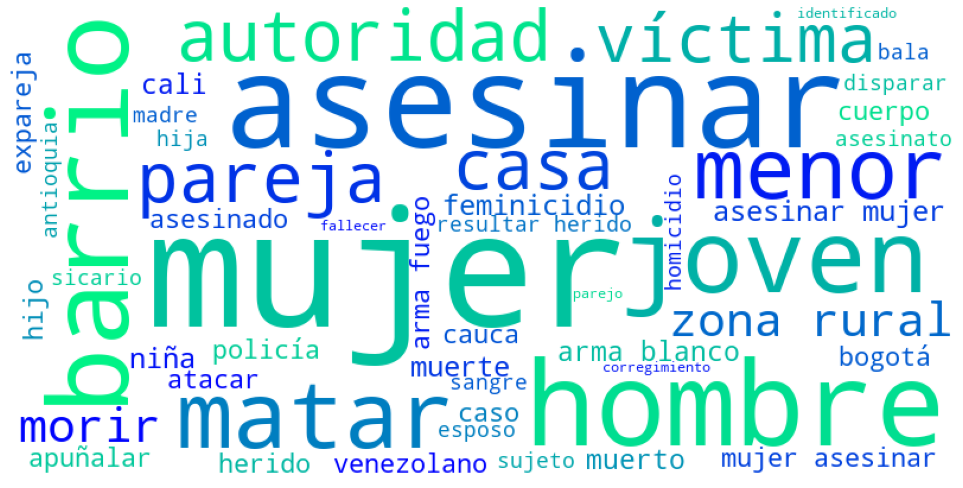

                         frecuencia
0                                  
arma blanco                     116
zona rural                       97
cadáver mujer                    38
compañera sentimental            37
pareja sentimental               37
arma fuego                       35
ataque sicarial                  33
caso feminicidio                 32
menor edad                       31
cuerpo mujer                     29
hombre mujer                     26
excompañero sentimental          25
impacto bala                     25
cuerpo vida                      24
14 año                           24
líder social                     23
vida mujer                       22
mujer muerto                     19
centro asistencial               19
asesinato mujer                  18
             frecuencia
0                      
mujer              1957
asesinar           1093
año                1082
hombre              709
barrio              652
municipio           512
matar           

In [12]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt


nlp_te=dossier['text_nlp'].tolist()

plt.figure(figsize=(17, 12))
wordcloud = WordCloud(width=800, height=400,background_color="white", max_words=50, stopwords=['año', 'edad', 'municipio', 'parecer',
                     'encontrar', 'persona', 'dejar', 'presentar', 'sector', 'mujer asesinar', 'hora', 'hallar', 'ocurrir', 'haber', 'registrar'],
                      colormap='winter').generate(' '.join(nlp_te))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

n_c=[i.lemma_ for i in nlp(' '.join(nlp_te)).noun_chunks if ' ' in i.lemma_]
n_c.sort()
n_c=pd.DataFrame(n_c)
n_c['frecuencia']=1

n_c=n_c.groupby(0).sum('frecuencia')
n_c=n_c.sort_values('frecuencia', ascending=False)
print(n_c[:20])

tokens=[i.lemma_ for i in nlp(' '.join(nlp_te))]
tokens.sort()
tokens=pd.DataFrame(tokens)
tokens['frecuencia']=1

tokens=tokens.groupby(0).sum('frecuencia')
tokens=tokens.sort_values('frecuencia', ascending=False)
print(tokens[:20])

El número óptimo de clusters es: 5


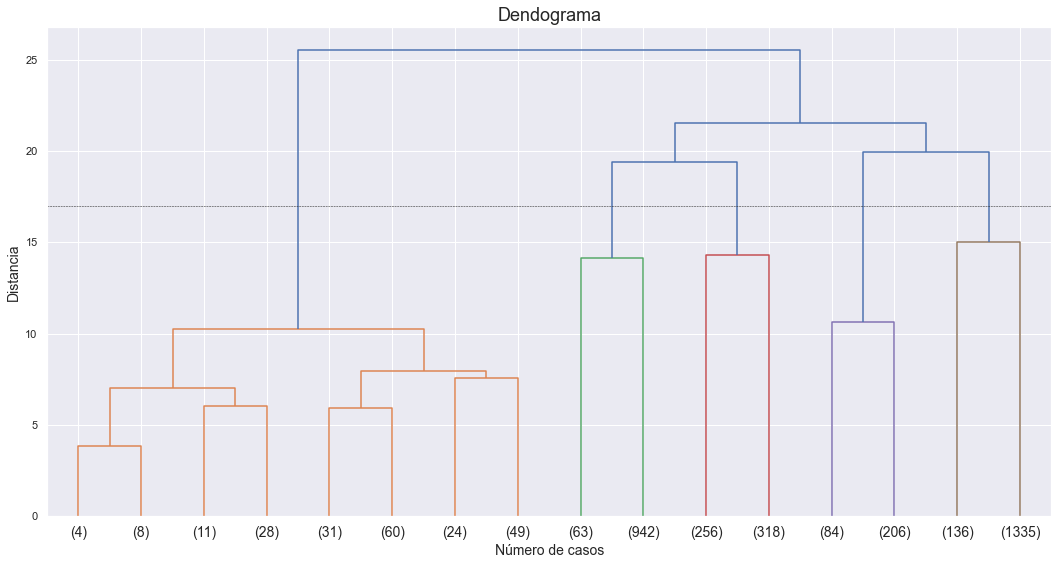

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
import matplotlib.pyplot as plt

tv = TfidfVectorizer(min_df=1, max_df=1.0, norm="l2", use_idf=True, smooth_idf=True)
tv_matrix = tv.fit_transform(nlp_te)

tfidf_df = pd.DataFrame(tv_matrix.toarray(), columns=tv.get_feature_names_out())

similarity_matrix = cosine_similarity(tv_matrix)
similarity_df = pd.DataFrame(similarity_matrix)

Z = linkage(similarity_matrix, "ward")
#ans=pd.DataFrame(Z,columns=["Document\Cluster 1", "Document\Cluster 2", "Distance", "Cluster Size"])


max_dist = 17
cluster_labels = fcluster(Z, max_dist, criterion='distance')

cluster_labels = pd.DataFrame(cluster_labels, columns=['ClusterLabel'])
try:
    dossier=dossier.drop(columns='ClusterLabel')
except:
    pass
dossier=pd.concat([dossier, cluster_labels], axis=1)
print('El número óptimo de clusters es: {}'.format(list(set(dossier.ClusterLabel))[-1]))

plt.figure(figsize=(18, 9))
plt.title('Dendograma', fontsize=18)
dendrogram(Z, p=3, truncate_mode='level')
plt.xlabel('Número de casos', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Distancia', fontsize=14)
plt.axhline(y=17.0, c='k', ls='--', lw=0.5)

In [4]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
import time

start = time.time()

cv = CountVectorizer(min_df=0., max_df=1.)
cv_matrix = cv.fit_transform(nlp_te)
cv_matrix = cv_matrix.toarray()

lda = LatentDirichletAllocation(n_components=5, max_iter=10000, random_state=0)
dt_matrix = lda.fit_transform(cv_matrix)                                 
features = pd.DataFrame(dt_matrix, columns=['T1', 'T2', 'T3', 'T4', 'T5'])
print(features)

vocab = cv.get_feature_names()
tt_matrix = lda.components_
contador=0
for topic_weights in tt_matrix:
    contador=contador+1
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights)]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 1]
    topic = [top for top, importance in topic]
    print()
    print('Las palabras clave del tema {}, son: {}'.format(contador, topic[0:9]))

    
    
end = time.time()
print(end - start)



            T1        T2        T3        T4        T5
0     0.011325  0.011528  0.011368  0.954419  0.011360
1     0.009640  0.009626  0.009615  0.009706  0.961414
2     0.013434  0.013544  0.555061  0.013467  0.404494
3     0.526321  0.008162  0.233513  0.223642  0.008361
4     0.015540  0.015505  0.015420  0.937810  0.015725
...        ...       ...       ...       ...       ...
3550  0.050125  0.798991  0.050236  0.050633  0.050015
3551  0.025329  0.898481  0.025210  0.025657  0.025322
3552  0.040106  0.838943  0.040248  0.040659  0.040045
3553  0.033540  0.033784  0.034098  0.865183  0.033396
3554  0.040737  0.043157  0.040025  0.042159  0.833923

[3555 rows x 5 columns]

Las palabras clave del tema 1, son: ['mujer', 'asesinar', 'casa', 'barrio', 'muerte', 'bala', 'pareja', 'feminicidio', 'municipio']

Las palabras clave del tema 2, son: ['mujer', 'hombre', 'asesinar', 'arma', 'sentimental', 'año', 'apuñalar', 'policía', 'agredir']

Las palabras clave del tema 3, son: ['cárcel', '

C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [5]:
features['cluster']=['T1' if x>y and x>z and x>k and x>m else 'T2' if y>k and y>z and y>m else 'T3' if z>k and z>m else 'T4' if k>m else 'T5'
                     for x,y,z,k,m in zip(features['T1'],features['T2'],features['T3'],features['T4'],features['T5'])]
print(features[features['cluster']=='T1'])
print(features[features['cluster']=='T2'])
print(features[features['cluster']=='T3'])
print(features[features['cluster']=='T4'])
print(features[features['cluster']=='T5'])

            T1        T2        T3        T4        T5 cluster
3     0.526321  0.008162  0.233513  0.223642  0.008361      T1
26    0.584243  0.007490  0.007283  0.393568  0.007416      T1
33    0.951917  0.011977  0.011798  0.012084  0.012223      T1
64    0.974611  0.006394  0.006283  0.006422  0.006290      T1
77    0.962985  0.009194  0.009173  0.009364  0.009285      T1
...        ...       ...       ...       ...       ...     ...
3532  0.500027  0.025565  0.025452  0.423689  0.025267      T1
3534  0.884138  0.028906  0.028590  0.029175  0.029191      T1
3538  0.865262  0.033558  0.033424  0.034027  0.033729      T1
3541  0.598139  0.325459  0.025302  0.025900  0.025200      T1
3546  0.446390  0.402241  0.050349  0.050259  0.050761      T1

[443 rows x 6 columns]
            T1        T2        T3        T4        T5 cluster
11    0.008154  0.645427  0.008123  0.008260  0.330038      T2
16    0.012896  0.948377  0.012556  0.013085  0.013086      T2
17    0.050918  0.796738  0.050

In [6]:
contador=0
common_words=['mujer', 'asesinar', 'matar', 'año', 'municipio', 'hombre']
for topic_weights in tt_matrix:
    contador=contador+1
    topic = [(token, weight) for token, weight in zip(vocab, topic_weights) if token not in common_words]
    topic = sorted(topic, key=lambda x: -x[1])
    topic = [item for item in topic if item[1] > 1]
    topic = [top for top, importance in topic]
    print()
    print('Las palabras clave del tema {}, son: {}'.format(contador, topic[0:15]))


Las palabras clave del tema 1, son: ['casa', 'barrio', 'muerte', 'bala', 'pareja', 'feminicidio', 'asesinado', 'noche', 'sangre', 'joven', 'caso', 'bello', 'víctima', 'morir', 'meta']

Las palabras clave del tema 2, son: ['arma', 'sentimental', 'apuñalar', 'policía', 'agredir', 'expareja', 'atacar', 'barrio', 'pareja', 'blanco', 'mamá', 'capturar', 'herido', 'sujeto', 'herir']

Las palabras clave del tema 3, son: ['cárcel', 'presunto', 'feminicidio', 'delito', 'enviar', 'fiscalía', 'responsable', 'agravado', 'policía', 'homicidio', 'apuñalar', 'prisión', 'capturar', 'venezolano', 'tentativo']

Las palabras clave del tema 4, son: ['barrio', 'pareja', 'vida', 'cali', 'muerte', 'sentimental', 'autoridad', 'joven', 'feminicidio', 'atacar', 'ataque', 'víctima', 'san', 'cauca', 'arma']

Las palabras clave del tema 5, son: ['muerto', 'hallar', 'herido', 'edad', 'encontrar', 'menor', 'cuerpo', 'barrio', 'niña', 'vida', 'joven', 'zona', 'cauca', 'autoridad', 'asesinado']


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from collections import Counter
import es_core_news_md

dossier = pd.read_excel('Dossier_3.xlsx')

# Our spaCy model:
nlp = es_core_news_md.load()
ner=[]
for text in nlp.pipe(dossier['text']):
    document = nlp(text)
    ner.append(document)
nlp.get_pipe('ner').labels
print(spacy.explain('LOC'))
print(spacy.explain('ORG'))
print(spacy.explain('PER'))
print(spacy.explain('MISC'))
dossier['LOC']=''
dossier['ORG']=''
for j in ['LOC','ORG']:
    ner_=[]
    for i in ner:
        ner__=[]
        for named_entity in i.ents:
            if named_entity.label_==j:
                ner__.append(named_entity)
        ner_.append(ner__)
    dossier[j]=ner_

Non-GPE locations, mountain ranges, bodies of water
Companies, agencies, institutions, etc.
Named person or family.
Miscellaneous entities, e.g. events, nationalities, products or works of art


In [2]:
import numpy as np
import re
dossier['medio']=['arma_blanca' if ('arma' in i.lower() and 'blanc' in i.lower()) or 'puñal' in i.lower() or 'machet' in i.lower() or 'cuchill' in i.lower() \
                  or 'degolla' in i.lower() or 'destornill' in i.lower() or 'botella' in i.lower() or 'hacha' in i.lower() \
                  or 'navaj' in i.lower() or 'cortopunz' in i.lower() or 'corto punz' in i.lower() else '' for i in dossier['text']]

dossier['medio']=[j+'arma_fuego' if ('arma' in i.lower() and 'fueg' in i.lower()) or ('cruzad' in i.lower() and 'fueg' in i.lower()) or'bala' in i.lower() or\
                  'dispar' in i.lower() or ' tiro' in i.lower() or 'tiro letal' in i.lower() or 'baleada' in i.lower() or 'quemarropa' in i.lower() or\
                  'quema ropa' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' prender_fuego' if ('fuego' in i.lower() or 'quema' in i.lower()) and 'arma_fuego' not in j else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' estrangulamiento' if 'estrang' in i.lower() or 'ahorc' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' asfixia' if 'asfix' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' golpes' if 'golp' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' tortura' if 'tortur' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' veneno' if 'veneno' in i.lower() or 'venena' in i.lower() or 'líquid' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' ahogamiento' if 'ahog' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' ácido' if 'ácido' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[j+' explosivo' if 'explos' in i.lower() or 'granada' in i.lower() else j+'' for i,j in zip(dossier['text'], dossier['medio'])]
dossier['medio']=[i.strip().split(' ') if i else np.NaN for i in dossier['medio']]

dossier['abuso_sexual']=[True if 'viola' in i.lower() or 'abus' in i.lower() or (('violen' in i.lower() or 'agres' in i.lower() or \
                'vejam' in i.lower()) and 'sex' in i.lower()) or 'viola' in i.lower() else False for i in dossier['text']]

#dossier['feminicidio_tentativa']=[1 if 'viva' in i.lower() or 'tentativa' in i.lower() else 0 for i in dossier['text']]

re1 = '[0-9]{1,2}[ \t\n\r\f\v]{,2}[.,]{,2}[a-z]{,3}[ \t\n\r\f\v]{,2}año'
re2 = '(?:un|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce) año'

dossier['edad_víctima']=[[j.split(' ')[0] for j in re.compile("(%s|%s)" % (re1, re2)).findall(i.lower())] for i in dossier['text']]
edades={'un':1,'dos':2,'tres':3,'cuatro':4,'cinco':5,'seis':6,'siete':7,'ocho':8,'nueve':9,'diez':10,'once':9,'doce':9}

dossier['edad_víctima']=[[str(edades[i]) if i in list(edades.keys()) else i for i in j] for j in dossier['edad_víctima']]

dossier['edad_víctima']=[i if i else np.NaN for i in dossier['edad_víctima']]


dossier['Victimario']=['Delincuencia' if 'sicar' in i.lower() or 'banda' in i.lower() or 'delincuencia' in i.lower() or 'ladrón' in i.lower() or 'atrac' in i.lower() or 'pistolero' in i.lower() \
                       or 'extraño' in i.lower() or 'desconocid' in i.lower() else '' for i in dossier['text']]

dossier['Victimario']=['Compañero sentimental' if (y=='' and 'novio' in i.lower() and 'exnov' not in i.lower()) or (y=='' and 'parej' in i.lower() and 'exparej' not in i.lower()) \
                    or (y=='' and 'espos' in i.lower() and 'exespos' not in i.lower()) or (y=='' and 'compañer' in i.lower() and 'excompañer' not in i.lower() and (y=='' and 'sentimen' in i.lower()\
                    or 'permanen' in i.lower())) or (y=='' and 'cónyuge' in i.lower() and 'excónyuge' not in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]

dossier['Victimario']=['Excompañero sentimental' if (y=='' and 'exnov' in i.lower()) or (y=='' and 'exparej' in i.lower()) \
                    or (y=='' and 'exespos' in i.lower()) or (y=='' and 'excompañer' in i.lower() and ('sentimen' in i.lower() or 'permanen' in i.lower())) \
                    or (y=='' and 'excónyuge'  in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Hijo' if y=='' and ('madre' in i.lower() or 'hijo' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Padre' if y=='' and (('hija' in i.lower() and 'hija de' not in i.lower()) or 'padre' in i.lower() or 'papá' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Padrastro' if y=='' and ('hijastra' in i.lower() or 'padrastro' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Primo' if y=='' and ('prima' in i.lower() or 'primo' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Nieto' if y=='' and ('abuela' in i.lower() or 'niet' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Abuelo' if y=='' and ('nieta' in i.lower() or 'abuelo' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Yerno' if y=='' and ('suegra' in i.lower() or 'yerno' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Cuñado' if (y=='' and 'cuñad' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Tío' if y=='' and ('sobrino' in i.lower() or ' tio ' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Otro familiar' if (y=='' and 'familia' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Paramilitar' if (y=='' and 'parmilita' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
dossier['Victimario']=['Guerrilla' if (y=='' and 'guerrrill' in i.lower()) else y if y!='' else '' for i,y in zip(dossier['text'],dossier['Victimario'])]
#dossier['Victimario']=['Fuerzas militares' if y=='' and ('polic' in i.lower() or 'ejército' in i.lower() or 'militar' in i.lower()) else y if y!='' else '' for i,y in\
#                       zip(dossier['text'],dossier['Victimario'])]

dossier['Victimario']=[i if i else np.NaN for i in dossier['Victimario']]
dossier['LOC']=[i if i else np.NaN for i in dossier['LOC']]
dossier['ORG']=[i if i else np.NaN for i in dossier['ORG']]

#for i in dossier[dossier['Victimario'].isna()]['text']:
#    print(i)
#dossier.to_excel('borrar.xlsx', index=False)

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import spacy
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()# Visualise inside a notebook
import es_core_news_md
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel
import time

start = time.time()
#dossier = pd.read_excel('Dossier_3.xlsx')   ##Se lee de la celda previa para conservar los cambios hechos


# Our spaCy model:
nlp = es_core_news_md.load()

removal= ['ADV','PRON','CCONJ','PUNCT','PART','DET','ADP','SPACE', 'SYM', 'NUM']
tokens = []

nlp.vocab['él'].is_stop = True
nlp.vocab['persona'].is_stop = True
nlp.vocab['cuyo'].is_stop = True
nlp.vocab['mujer'].is_stop = True
nlp.vocab['asesinar'].is_stop = True
nlp.vocab['matar'].is_stop = True
nlp.vocab['año'].is_stop = True
nlp.vocab['hombre'].is_stop = True
nlp.vocab['municipio'].is_stop = True
nlp.vocab['barrio'].is_stop = True
nlp.vocab['vida'].is_stop = True
nlp.vocab['san'].is_stop = True
nlp.vocab['santa'].is_stop = True
nlp.vocab['caso'].is_stop = True
nlp.vocab['hora'].is_stop = True

nlp.vocab['edad'].is_stop = True
nlp.vocab['frente'].is_stop = True
nlp.vocab['volver'].is_stop = True
nlp.vocab['soachaber'].is_stop = True
nlp.vocab['doble'].is_stop = True
nlp.vocab['integrante'].is_stop = True
nlp.vocab['resultar'].is_stop = True

for summary in nlp.pipe(dossier['text']):
    proj_tok = [token.lemma_.lower() for token in summary if token.pos_ not in removal and len(token.lemma_)>2]
    proj_tok=nlp(' '.join(proj_tok))
    proj_tok = [token.lemma_.lower() for token in proj_tok if not token.is_stop]
    tokens.append(proj_tok)
    proj_tok=nlp(' '.join(proj_tok))
    proj_tok = [token.lemma_.lower() for token in proj_tok.noun_chunks if ' ' in token.lemma_]
    tokens[-1]=tokens[-1]+proj_tok

# Add tokens to new column
dossier['tokens'] = tokens


# Create dictionary
# I will apply the Dictionary Object from Gensim, which maps each word to their unique ID:
dictionary = Dictionary(dossier['tokens'])
#print(dictionary.token2id)

# Filter dictionary
dictionary.filter_extremes(no_below=15, no_above=0.55, keep_n=1000)

# Create corpus
corpus = [dictionary.doc2bow(doc) for doc in dossier['tokens']]

# LDA model building
#lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=10, workers = 4, passes=10)

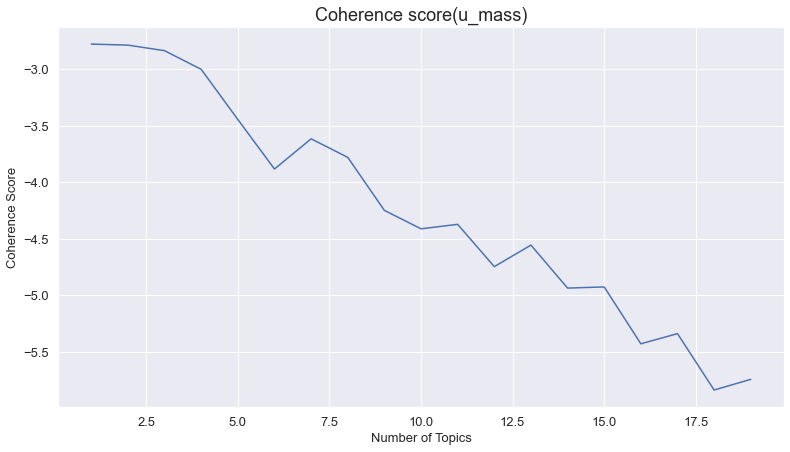

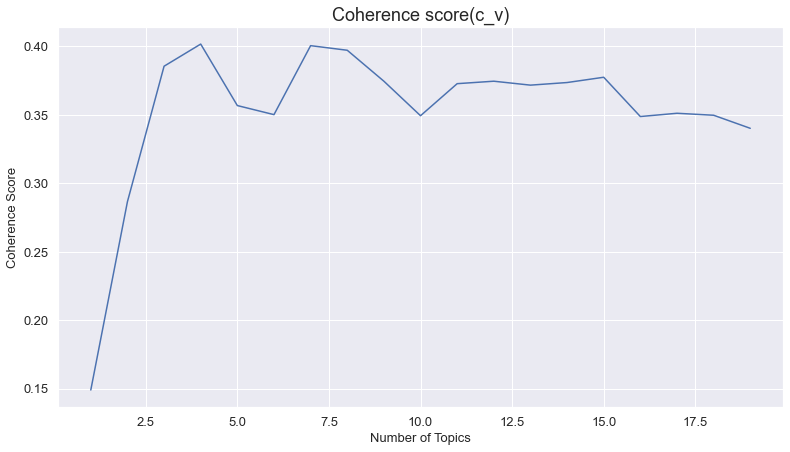

824.4159905910492


In [7]:


# Coherence score using C_umass:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    topics.append(i)
    score.append(cm.get_coherence())
plt.figure(figsize=(13, 7))
_=plt.plot(topics, score)
_=plt.title('Coherence score(u_mass)', fontsize=18)
_=plt.xlabel('Number of Topics', fontsize=13)
_=plt.xticks(fontsize=13)
_=plt.ylabel('Coherence Score', fontsize=13)
_=plt.yticks(fontsize=13)
plt.show()

# Coherence score using C_v:
topics = []
score = []
for i in range(1,20,1):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=10, num_topics=i, workers = 4, passes=10, random_state=100)
    cm = CoherenceModel(model=lda_model, texts = dossier['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    topics.append(i)
    score.append(cm.get_coherence())
plt.figure(figsize=(13, 7))
_=plt.plot(topics, score)
_=plt.title('Coherence score(c_v)', fontsize=18)
_=plt.xlabel('Number of Topics', fontsize=13)
_=plt.xticks(fontsize=13)
_=plt.ylabel('Coherence Score', fontsize=13)
_=plt.yticks(fontsize=13)
plt.show()

end = time.time()
print(end - start)

In [8]:
# Optimal model
lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=50, num_topics=4, workers = 4, passes=100, random_state=20)

# Print topics
lda_model.print_topics(-1)

# Where does a text belong to

end = time.time()
print(end - start)

1029.4424078464508


In [9]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)


C:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


Clusters:
------
![Clusters](https://github.com/dagarciaal/Seguimiento_casos_feminicidio_Colombia/blob/main/clusters.PNG?raw=true "Clusters")

In [10]:
dossier['topic'] = [sorted(lda_model[corpus][text], key=lambda x: x[1], reverse=True)[0][0]+1 for text in range(len(dossier['text']))]
dossier.topic.value_counts()

1    1079
4     955
3     769
2     752
Name: topic, dtype: int64

In [11]:
dossier.to_excel('Dossier_final.xlsx', index=False)

Análisis sensibilidad:
------

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from collections import Counter
import es_core_news_md

dossier_s = pd.read_excel('Dossier_sensibilidad.xlsx')

# Our spaCy model:
nlp = es_core_news_md.load()
ner=[]
for text in nlp.pipe(dossier_s['text']):
    document = nlp(text)
    ner.append(document)
nlp.get_pipe('ner').labels
print(spacy.explain('LOC'))
print(spacy.explain('ORG'))
print(spacy.explain('PER'))
print(spacy.explain('MISC'))
dossier_s['LOC']=''
dossier_s['ORG']=''
for j in ['LOC','ORG']:
    ner_=[]
    for i in ner:
        ner__=[]
        for named_entity in i.ents:
            if named_entity.label_==j:
                ner__.append(named_entity)
        ner_.append(ner__)
    dossier_s[j]=ner_

Non-GPE locations, mountain ranges, bodies of water
Companies, agencies, institutions, etc.
Named person or family.
Miscellaneous entities, e.g. events, nationalities, products or works of art


In [15]:
import numpy as np
import re
dossier_s['medio']=['arma_blanca' if ('arma' in i.lower() and 'blanc' in i.lower()) or 'puñal' in i.lower() or 'machet' in i.lower() or 'cuchill' in i.lower() \
                  or 'degolla' in i.lower() or 'destornill' in i.lower() or 'botella' in i.lower() or 'hacha' in i.lower() \
                  or 'navaj' in i.lower() or 'cortopunz' in i.lower() or 'corto punz' in i.lower() else '' for i in dossier_s['text']]

dossier_s['medio']=[j+'arma_fuego' if ('arma' in i.lower() and 'fueg' in i.lower()) or ('cruzad' in i.lower() and 'fueg' in i.lower()) or'bala' in i.lower() or\
                  'dispar' in i.lower() or ' tiro' in i.lower() or 'tiro letal' in i.lower() or 'baleada' in i.lower() or 'quemarropa' in i.lower() or\
                  'quema ropa' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' prender_fuego' if ('fuego' in i.lower() or 'quema' in i.lower()) and 'arma_fuego' not in j else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' estrangulamiento' if 'estrang' in i.lower() or 'ahorc' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' asfixia' if 'asfix' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' golpes' if 'golp' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' tortura' if 'tortur' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' veneno' if 'veneno' in i.lower() or 'venena' in i.lower() or 'líquid' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' ahogamiento' if 'ahog' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' ácido' if 'ácido' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[j+' explosivo' if 'explos' in i.lower() or 'granada' in i.lower() else j+'' for i,j in zip(dossier_s['text'], dossier_s['medio'])]
dossier_s['medio']=[i.strip().split(' ') if i else np.NaN for i in dossier_s['medio']]

dossier_s['abuso_sexual']=[True if 'viola' in i.lower() or 'abus' in i.lower() or (('violen' in i.lower() or 'agres' in i.lower() or \
                'vejam' in i.lower()) and 'sex' in i.lower()) or 'viola' in i.lower() else False for i in dossier_s['text']]

#dossier_s['feminicidio_tentativa']=[1 if 'viva' in i.lower() or 'tentativa' in i.lower() else 0 for i in dossier_s['text']]

re1 = '[0-9]{1,2}[ \t\n\r\f\v]{,2}[.,]{,2}[a-z]{,3}[ \t\n\r\f\v]{,2}año'
re2 = '(?:un|dos|tres|cuatro|cinco|seis|siete|ocho|nueve|diez|once|doce) año'

dossier_s['edad_víctima']=[[j.split(' ')[0] for j in re.compile("(%s|%s)" % (re1, re2)).findall(i.lower())] for i in dossier_s['text']]
edades={'un':1,'dos':2,'tres':3,'cuatro':4,'cinco':5,'seis':6,'siete':7,'ocho':8,'nueve':9,'diez':10,'once':9,'doce':9}

dossier_s['edad_víctima']=[[str(edades[i]) if i in list(edades.keys()) else i for i in j] for j in dossier_s['edad_víctima']]

dossier_s['edad_víctima']=[i if i else np.NaN for i in dossier_s['edad_víctima']]


dossier_s['Victimario']=['Delincuencia' if 'sicar' in i.lower() or 'banda' in i.lower() or 'delincuencia' in i.lower() or 'ladrón' in i.lower() or 'atrac' in i.lower() or 'pistolero' in i.lower() \
                       or 'extraño' in i.lower() or 'desconocid' in i.lower() else '' for i in dossier_s['text']]

dossier_s['Victimario']=['Compañero sentimental' if (y=='' and 'novio' in i.lower() and 'exnov' not in i.lower()) or (y=='' and 'parej' in i.lower() and 'exparej' not in i.lower()) \
                    or (y=='' and 'espos' in i.lower() and 'exespos' not in i.lower()) or (y=='' and 'compañer' in i.lower() and 'excompañer' not in i.lower() and (y=='' and 'sentimen' in i.lower()\
                    or 'permanen' in i.lower())) or (y=='' and 'cónyuge' in i.lower() and 'excónyuge' not in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]

dossier_s['Victimario']=['Excompañero sentimental' if (y=='' and 'exnov' in i.lower()) or (y=='' and 'exparej' in i.lower()) \
                    or (y=='' and 'exespos' in i.lower()) or (y=='' and 'excompañer' in i.lower() and ('sentimen' in i.lower() or 'permanen' in i.lower())) \
                    or (y=='' and 'excónyuge'  in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Hijo' if y=='' and ('madre' in i.lower() or 'hijo' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Padre' if y=='' and (('hija' in i.lower() and 'hija de' not in i.lower()) or 'padre' in i.lower() or 'papá' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Padrastro' if y=='' and ('hijastra' in i.lower() or 'padrastro' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Primo' if y=='' and ('prima' in i.lower() or 'primo' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Nieto' if y=='' and ('abuela' in i.lower() or 'niet' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Abuelo' if y=='' and ('nieta' in i.lower() or 'abuelo' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Yerno' if y=='' and ('suegra' in i.lower() or 'yerno' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Cuñado' if (y=='' and 'cuñad' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Tío' if y=='' and ('sobrino' in i.lower() or ' tio ' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Otro familiar' if (y=='' and 'familia' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Paramilitar' if (y=='' and 'parmilita' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
dossier_s['Victimario']=['Guerrilla' if (y=='' and 'guerrrill' in i.lower()) else y if y!='' else '' for i,y in zip(dossier_s['text'],dossier_s['Victimario'])]
#dossier_s['Victimario']=['Fuerzas militares' if y=='' and ('polic' in i.lower() or 'ejército' in i.lower() or 'militar' in i.lower()) else y if y!='' else '' for i,y in\
#                       zip(dossier_s['text'],dossier_s['Victimario'])]

dossier_s['Victimario']=[i if i else np.NaN for i in dossier_s['Victimario']]
dossier_s['LOC']=[i if i else np.NaN for i in dossier_s['LOC']]
dossier_s['ORG']=[i if i else np.NaN for i in dossier_s['ORG']]

#for i in dossier_s[dossier_s['Victimario'].isna()]['text']:
#    print(i)
dossier_s.to_excel('Dossier_sensibilidad_final.xlsx', index=False)